In [54]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [55]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aprab\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [56]:
# Reading the stock price and headlines data
stock_price = pd.read_csv('GOOG.csv')
stock_headlines = pd.read_csv('india-news-headlines.csv')

In [57]:
#Displaying Stock news headlines dataset
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [58]:
#displaying stock price dataset of Google
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813290,51.835709,47.800831,49.982655,49.982655,44871361
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942874
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342897
3,2004-08-24,55.412300,55.591629,51.591621,52.239197,52.239197,15319808
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232276


In [59]:
#Checking for any nulls in the datasets
stock_headlines.isna().any(),stock_price.isna().any()

(publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool,
 Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool)

### Stock Price Data

In [60]:
#Cleaning the Data

# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the column 'Date' into type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# Required Columns
stock_price = stock_price.filter(['Date', 'Close', 'High', 'Low', 'Open','Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,High,Low,Open,Volume
Date,,,,,
2004-08-19,49.982655,51.835709,47.800831,49.813290,44871361
2004-08-20,53.952770,54.336334,50.062355,50.316402,22942874
2004-08-23,54.495735,56.528118,54.321388,55.168217,18342897
2004-08-24,52.239197,55.591629,51.591621,55.412300,15319808
2004-08-25,52.802086,53.798351,51.746044,52.284027,9232276
...,...,...,...,...,...
2021-08-09,2760.040039,2766.429932,2728.574951,2738.979980,618700
2021-08-10,2761.929932,2771.030029,2744.530029,2761.590088,801700
2021-08-11,2753.790039,2776.955078,2747.000000,2765.659912,760200


### Stock News Headlines

In [61]:
#Cleaning Data

# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the column 'Date' to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# Required Headlines
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


### Combining Stock Prices Data and Headlines Data 

In [62]:
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)
stock_data

,Close,High,Low,Open,Volume,headline_text
2004-08-19,49.982655,51.835709,47.800831,49.813290,44871361.0,"Hello! You've got a call,Foreign Indians,SACRE..."
2004-08-20,53.952770,54.336334,50.062355,50.316402,22942874.0,"Rapist had free run at empty station,Police bu..."
2004-08-23,54.495735,56.528118,54.321388,55.168217,18342897.0,"Among the best; Down Under,Opportunities galor..."
2004-08-24,52.239197,55.591629,51.591621,55.412300,15319808.0,"Harried A-I passengers to get $400 each,GIPCL ..."
2004-08-25,52.802086,53.798351,51.746044,52.284027,9232276.0,LEADER ARTICLEBRTrade Honestly Power sector br...
...,...,...,...,...,...,...
2020-12-24,1738.849976,1746.000000,1729.109985,1735.000000,346800.0,How to set the mood for sex during cold winter...
2020-12-28,1776.089966,1790.728027,1746.334961,1751.635010,1393000.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,1758.719971,1792.439941,1756.089966,1787.790039,1299400.0,Man recovers charred remains of 'thief' from h...
2020-12-30,1739.520020,1765.094971,1725.599976,1762.010010,1306100.0,Numerology Readings 30 December 2020: Predicti...


### Calculating Sentiment Scores 

In [63]:
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,High,Low,Open,Volume,headline_text,compound,negative,neutral,positive
2004-08-19,49.982655,51.835709,47.800831,49.813290,44871361.0,"Hello! You've got a call,Foreign Indians,SACRE...",,,,
2004-08-20,53.952770,54.336334,50.062355,50.316402,22942874.0,"Rapist had free run at empty station,Police bu...",,,,
2004-08-23,54.495735,56.528118,54.321388,55.168217,18342897.0,"Among the best; Down Under,Opportunities galor...",,,,
2004-08-24,52.239197,55.591629,51.591621,55.412300,15319808.0,"Harried A-I passengers to get $400 each,GIPCL ...",,,,
2004-08-25,52.802086,53.798351,51.746044,52.284027,9232276.0,LEADER ARTICLEBRTrade Honestly Power sector br...,,,,


In [64]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,High,Low,Open,Volume,headline_text,compound,negative,neutral,positive
2004-08-19,49.982655,51.835709,47.800831,49.813290,44871361.0,"Hello! You've got a call,Foreign Indians,SACRE...",-0.9982,0.150,0.783,0.067
2004-08-20,53.952770,54.336334,50.062355,50.316402,22942874.0,"Rapist had free run at empty station,Police bu...",-0.9884,0.103,0.830,0.068
2004-08-23,54.495735,56.528118,54.321388,55.168217,18342897.0,"Among the best; Down Under,Opportunities galor...",-0.9986,0.156,0.768,0.076
2004-08-24,52.239197,55.591629,51.591621,55.412300,15319808.0,"Harried A-I passengers to get $400 each,GIPCL ...",-0.9951,0.101,0.856,0.044
2004-08-25,52.802086,53.798351,51.746044,52.284027,9232276.0,LEADER ARTICLEBRTrade Honestly Power sector br...,-0.9015,0.125,0.756,0.119


In [65]:
# Removing the Headlines as we already have the sentiment scores
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2004-08-19,49.982655,-0.9982,0.150,0.783,0.067,49.813290,51.835709,47.800831,44871361.0
2004-08-20,53.952770,-0.9884,0.103,0.830,0.068,50.316402,54.336334,50.062355,22942874.0
2004-08-23,54.495735,-0.9986,0.156,0.768,0.076,55.168217,56.528118,54.321388,18342897.0
2004-08-24,52.239197,-0.9951,0.101,0.856,0.044,55.412300,55.591629,51.591621,15319808.0
2004-08-25,52.802086,-0.9015,0.125,0.756,0.119,52.284027,53.798351,51.746044,9232276.0


In [66]:
# Writing the data into stock_data.csv
stock_data.to_csv('stock_data.csv')

### Reading our Cleaned Data 

In [67]:
stock_data = pd.read_csv('stock_data.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)
stock_data.set_index('Date', inplace=True)
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2004-08-19,49.982655,-0.9982,0.150,0.783,0.067,49.813290,51.835709,47.800831,44871361.0
2004-08-20,53.952770,-0.9884,0.103,0.830,0.068,50.316402,54.336334,50.062355,22942874.0
2004-08-23,54.495735,-0.9986,0.156,0.768,0.076,55.168217,56.528118,54.321388,18342897.0
2004-08-24,52.239197,-0.9951,0.101,0.856,0.044,55.412300,55.591629,51.591621,15319808.0
2004-08-25,52.802086,-0.9015,0.125,0.756,0.119,52.284027,53.798351,51.746044,9232276.0


In [68]:
stock_data.shape

(4122, 9)

In [69]:
# checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [70]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,4122.000000,4122.000000,4122.000000,4122.000000,4122.000000,4122.000000,4122.000000,4122.000000,4.122000e+03
mean,550.564302,-0.892529,0.129195,0.782771,0.088027,550.468219,555.773507,545.076599,6.770475e+06
std,407.780142,0.422615,0.021237,0.027019,0.016154,407.370551,411.511678,403.690264,7.928366e+06
min,49.818268,-1.000000,0.053000,0.637000,0.024000,49.409801,50.680038,47.800831,7.922000e+03
25%,241.299301,-0.999800,0.117000,0.765000,0.078000,241.051476,243.973026,238.824821,1.689050e+06
50%,349.995621,-0.999500,0.130000,0.779000,0.088000,351.290772,354.924652,347.285782,4.075419e+06
75%,786.140015,-0.996900,0.143000,0.798000,0.098000,785.029984,791.212738,782.598511,8.665409e+06
max,1827.989990,1.000000,0.216000,0.903000,0.255000,1824.520020,1847.199951,1822.650024,8.254163e+07


### Exploratory Data Analysis(EDA) of Stock Data

Text(0, 0.5, 'Close Price ($)')

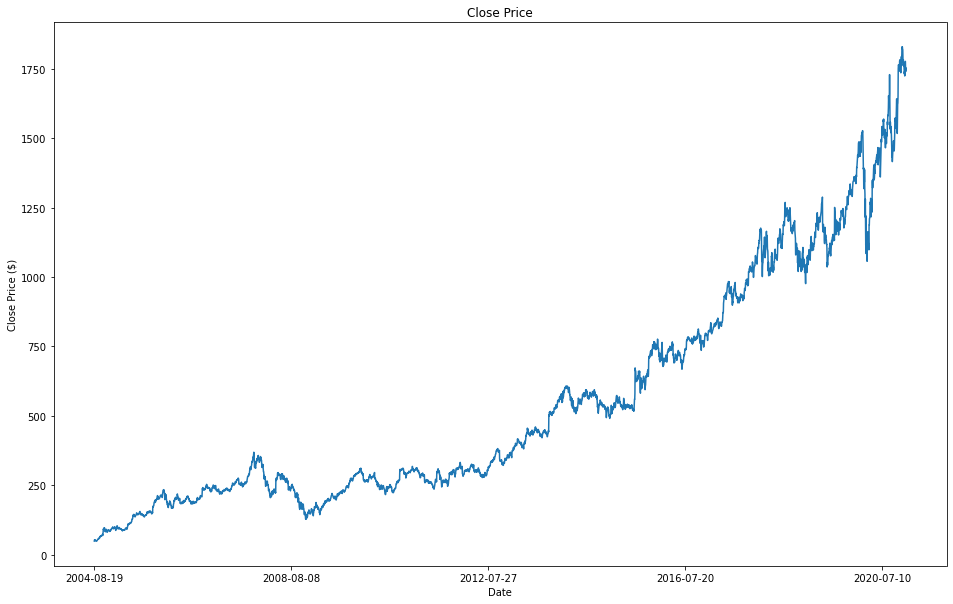

In [71]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [72]:
# calculating rolling mean of 7 days
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2004-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-27,52.871823,-0.977614,0.135000,0.785429,0.080000,52.731635,54.281540,51.472070,1.772559e+07
2004-08-30,52.990663,-0.977114,0.127714,0.794429,0.078286,53.107369,54.383301,51.902599,1.206133e+07
2004-08-31,52.567962,-0.971729,0.129857,0.785714,0.084714,53.199168,54.001162,52.020727,9.489665e+06


<AxesSubplot:xlabel='Date'>

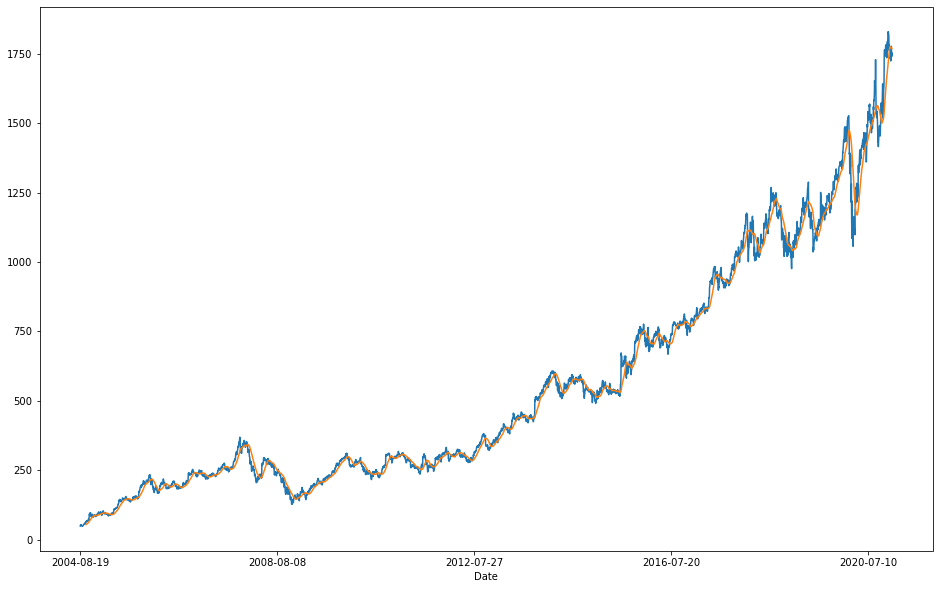

In [73]:
# Plotting 30 day Rolling Mean of close price and the Close price
plt.figure(figsize=(16,10))

stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

### Data Preparation for Modelling 

In [74]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

print("No. of records in Training Data:", train_end)
print("No. of records in Test Data:", total_data - train_end)

No. of records in Training Data: 3296
No. of records in Test Data: 826


In [75]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
open_price = stock_data.iloc[start:total_data,5] 
high = stock_data.iloc[start:total_data,6] 
low = stock_data.iloc[start:total_data,7] 
volume = stock_data.iloc[start:total_data,8] 
close_price = stock_data.iloc[start:total_data,0] 
compound = stock_data.iloc[start:total_data,1] 
negative = stock_data.iloc[start:total_data,2] 
neutral = stock_data.iloc[start:total_data,3] 
positive = stock_data.iloc[start:total_data,4] 

print("Close Price:")
close_price

Close Price:


Date
2004-08-20      53.952770
2004-08-23      54.495735
2004-08-24      52.239197
2004-08-25      52.802086
2004-08-26      53.753517
                 ...     
2020-12-24    1738.849976
2020-12-28    1776.089966
2020-12-29    1758.719971
2020-12-30    1739.520020
2020-12-31    1751.880005
Name: Close, Length: 4121, dtype: float64

In [76]:
# shifting next day close (The Expected Output)
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(15)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2004-08-20,53.952770,54.495735,-0.9884,-0.9986,22942874.0,50.316402,54.336334,50.062355
2004-08-23,54.495735,52.239197,-0.9986,-0.9951,18342897.0,55.168217,56.528118,54.321388
2004-08-24,52.239197,52.802086,-0.9951,-0.9015,15319808.0,55.412300,55.591629,51.591621
2004-08-25,52.802086,53.753517,-0.9015,-0.9995,9232276.0,52.284027,53.798351,51.746044
2004-08-26,53.753517,52.876804,-0.9995,-0.9620,7128620.0,52.279045,53.773445,52.134586
2004-08-27,52.876804,50.814533,-0.9620,-0.9947,6241307.0,53.848164,54.107193,52.647663
2004-08-30,50.814533,50.993862,-0.9947,-0.9507,5221498.0,52.443428,52.548038,50.814533
2004-08-31,50.993862,49.937820,-0.9507,-0.9921,4941252.0,50.958992,51.661362,50.889256
2004-09-01,49.937820,50.565468,-0.9921,-0.8064,9181687.0,51.158245,51.292744,49.648903


In [77]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2004-08-20      54.495735
2004-08-23      52.239197
2004-08-24      52.802086
2004-08-25      53.753517
2004-08-26      52.876804
                 ...     
2020-12-23    1738.849976
2020-12-24    1776.089966
2020-12-28    1758.719971
2020-12-29    1739.520020
2020-12-30    1751.880005
Name: close_price_shifted, Length: 4120, dtype: float64

In [78]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2004-08-20,53.952770,-0.9884,-0.9986,22942874.0,50.316402,54.336334,50.062355
2004-08-23,54.495735,-0.9986,-0.9951,18342897.0,55.168217,56.528118,54.321388
2004-08-24,52.239197,-0.9951,-0.9015,15319808.0,55.412300,55.591629,51.591621
2004-08-25,52.802086,-0.9015,-0.9995,9232276.0,52.284027,53.798351,51.746044
2004-08-26,53.753517,-0.9995,-0.9620,7128620.0,52.279045,53.773445,52.134586
...,...,...,...,...,...,...,...
2020-12-23,1732.380005,-0.9996,-0.9971,1033800.0,1728.109985,1747.989990,1725.040039
2020-12-24,1738.849976,-0.9971,-0.9997,346800.0,1735.000000,1746.000000,1729.109985
2020-12-28,1776.089966,-0.9997,-0.9998,1393000.0,1751.635010,1790.728027,1746.334961


In [79]:
# Scalling the Datasets into a feature range of (-1,1) as they are time series data

scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

x, y

(array([[-0.99534972, -0.9884    , -0.9986    , ..., -0.99897854,
         -0.99592958, -0.9991236 ],
        [-0.99473902, -0.9986    , -0.9951    , ..., -0.99351205,
         -0.99348955, -0.99432026],
        [-0.99727706, -0.9951    , -0.9015    , ..., -0.99323704,
         -0.99453211, -0.99739889],
        ...,
        [ 0.94162541, -0.9997    , -0.9998    , ...,  0.91788114,
          0.93713187,  0.91393191],
        [ 0.92208849, -0.9998    , -0.9998    , ...,  0.95861668,
          0.93903768,  0.9249336 ],
        [ 0.90049333, -0.9998    , -0.9996    , ...,  0.92957056,
          0.90859552,  0.890547  ]]),
 array([[-0.99473902],
        [-0.99727706],
        [-0.99664395],
        ...,
        [ 0.92208849],
        [ 0.90049333],
        [ 0.91439524]]))

In [80]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

In [81]:
# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (3296, 7) and y: (3296, 1)
Number of rows and columns in the Test set X: (823, 7) and y: (823, 1)


In [82]:
# reshaping the feature dataset for feeding into the LSTM model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (3296, 7, 1)
Shape of Test set X: (823, 7, 1)


### LSTM Model for the Stock Data 

In [83]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 100)            40800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [84]:
# compiling and fitting the model
model.compile(loss='mse' , optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
330/330 [==============================] - 10s 14ms/step - loss: 0.0625 - val_loss: 0.2211
Epoch 2/10
330/330 [==============================] - 3s 10ms/step - loss: 0.0161 - val_loss: 0.0042
Epoch 3/10
330/330 [==============================] - 4s 11ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 4/10
330/330 [==============================] - 4s 11ms/step - loss: 0.0016 - val_loss: 2.0037e-04
Epoch 5/10
330/330 [==============================] - 4s 11ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 6/10
330/330 [==============================] - 4s 11ms/step - loss: 0.0014 - val_loss: 1.9198e-04
Epoch 7/10
330/330 [==============================] - 4s 13ms/step - loss: 0.0013 - val_loss: 2.1468e-04
Epoch 8/10
330/330 [==============================] - 4s 13ms/step - loss: 0.0014 - val_loss: 2.2828e-04
Epoch 9/10
330/330 [==============================] - 4s 12ms/step - loss: 0.0011 - val_loss: 4.9061e-04
Epoch 10/10
330/330 [==============================] - 4s 12ms/step - 

In [85]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model saved!!!')

Model saved!!!


### Predictions 

In [86]:
predictions = model.predict(X_test) 
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

print('Predictions:')
predictions[0:10]

Predictions:


array([[927.57367],
       [932.4957 ],
       [944.7155 ],
       [952.11365],
       [962.9503 ],
       [964.34235],
       [961.26733],
       [963.4066 ],
       [969.44   ],
       [978.63995]], dtype=float32)

### Model Evaluation 

In [87]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,3))
print('Test Loss =', round(test_loss,3))

823/823 [==============================] - 2s 2ms/step - loss: 0.0012- ETA: 0s - loss: 0.0011  
Train Loss = 0.0
Test Loss = 0.001


In [90]:
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 30.7265


### Plotting the Predictions 

In [88]:
# unscaling the test x_test,y_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

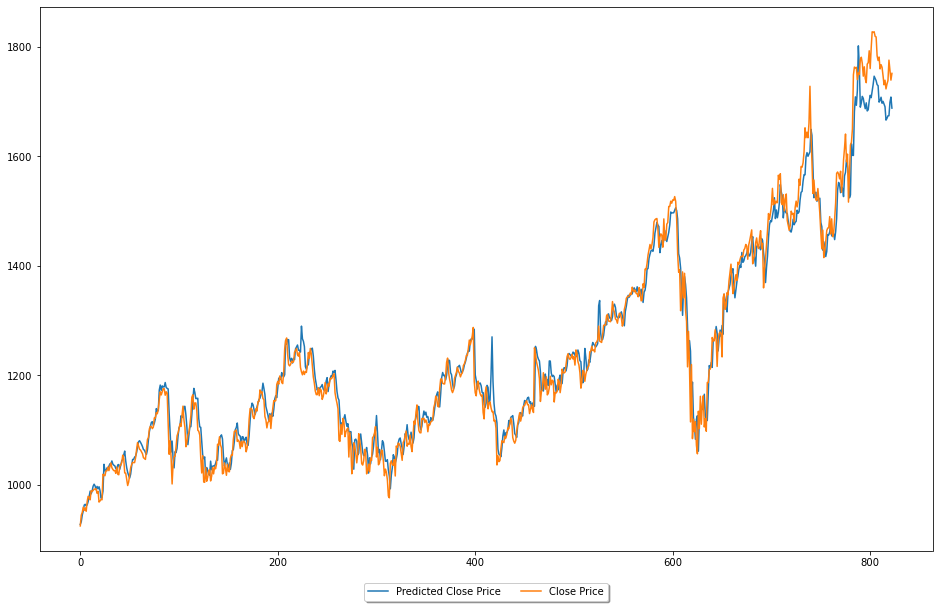

In [89]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()